# 1. Import and path setting
Installing Kagglehub and downloading dataset via Kaggle API

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")

print("Path to dataset files:", path)

/Users/yannik/anaconda3/envs/keras_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/yannik/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2


Defining the paths to training, validation, and testing folder. Counting the number of folders and files.

In [4]:
import os

# Define the dataset path
root_folder = "/Users/yannik/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2"

data_dir = os.path.join(root_folder, 'new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/')

test_path = os.path.join(root_folder, 'test/test')
train_path = os.path.join(data_dir, 'train')
valid_path = os.path.join(data_dir, 'valid')

# Count the number of folders in a directory
def count_folders(path):
    if os.path.exists(path):
        return len([d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))])
    else:
        print(f"Path does not exist: {path}")
        return 0

# Count the number of files in a directory
def count_files(path):
    if os.path.exists(path):
        return len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
    else:
        print(f"Path does not exist: {path}")
        return 0

# Function to count files in each folder of a given directory
def count_files_in_folders(path):
    if not os.path.exists(path):
        print(f"Path does not exist: {path}")
        return {}

    folder_file_counts = {}
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
            folder_file_counts[folder] = file_count

    return folder_file_counts

# Print counts
print(f"Number of folders in train_path: {count_folders(train_path)}")
print(f"Number of folders in valid_path: {count_folders(valid_path)}")
print(f"Number of files in test_path: {count_files(test_path)}")
print('-------------------------------------------------------------------')
# Count files in each folder
train_folder_counts = count_files_in_folders(train_path)
valid_folder_counts = count_files_in_folders(valid_path)
# Display results
print("Files in each folder (train_path):")
for folder, count in train_folder_counts.items():
    print(f"{folder}: {count} files")

print("\nFiles in each folder (valid_path):")
for folder, count in valid_folder_counts.items():
    print(f"{folder}: {count} files")

Number of folders in train_path: 38
Number of folders in valid_path: 38
Number of files in test_path: 33
-------------------------------------------------------------------
Files in each folder (train_path):
Strawberry___healthy: 1824 files
Grape___Black_rot: 1888 files
Potato___Early_blight: 1939 files
Blueberry___healthy: 1816 files
Corn_(maize)___healthy: 1859 files
Tomato___Target_Spot: 1827 files
Peach___healthy: 1728 files
Potato___Late_blight: 1939 files
Tomato___Late_blight: 1851 files
Tomato___Tomato_mosaic_virus: 1790 files
Pepper,_bell___healthy: 1988 files
Orange___Haunglongbing_(Citrus_greening): 2010 files
Tomato___Leaf_Mold: 1882 files
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1722 files
Cherry_(including_sour)___Powdery_mildew: 1683 files
Apple___Cedar_apple_rust: 1760 files
Tomato___Bacterial_spot: 1702 files
Grape___healthy: 1692 files
Tomato___Early_blight: 1920 files
Corn_(maize)___Common_rust_: 1907 files
Grape___Esca_(Black_Measles): 1920 files
Raspberry___healt

Importing all libraries

In [68]:
from tensorflow.keras.backend import clear_session

clear_session()

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import scipy

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.applications.vgg16 import VGG16

from livelossplot.inputs.keras import PlotLossesCallback

# 2 Feature extraction with VGG16

In [19]:
# Define the image generators for the training and validation set

batch_size = 32
num_classes = 38
img_size = (224, 224)

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)  # randomize the order of the samples to avoid overfitting

validation_generator = validation_datagen.flow_from_directory(
    valid_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)  # randomize the order of the samples to avoid overfitting

# Import the VGG16 model as a base line
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# base_model.trainable = False  #  freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for classification part 
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(rate=0.2))
model.add(Dense(512, activation="relu"))
model.add(Dropout(rate=0.2))
model.add(Dense(num_classes, activation="softmax"))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


I will first try an EarlyStopping callback which monitors the val_loss.

In [9]:
# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Save model with best accuracy
checkpoint_best = ModelCheckpoint(
    'model_VGG16_2_best_accuracy.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Plot summary of training
plot_loss_1 = PlotLossesCallback()

# Combine all callbacks
callbacks = [early_stopping, reduce_lr, checkpoint_best, plot_loss_1]

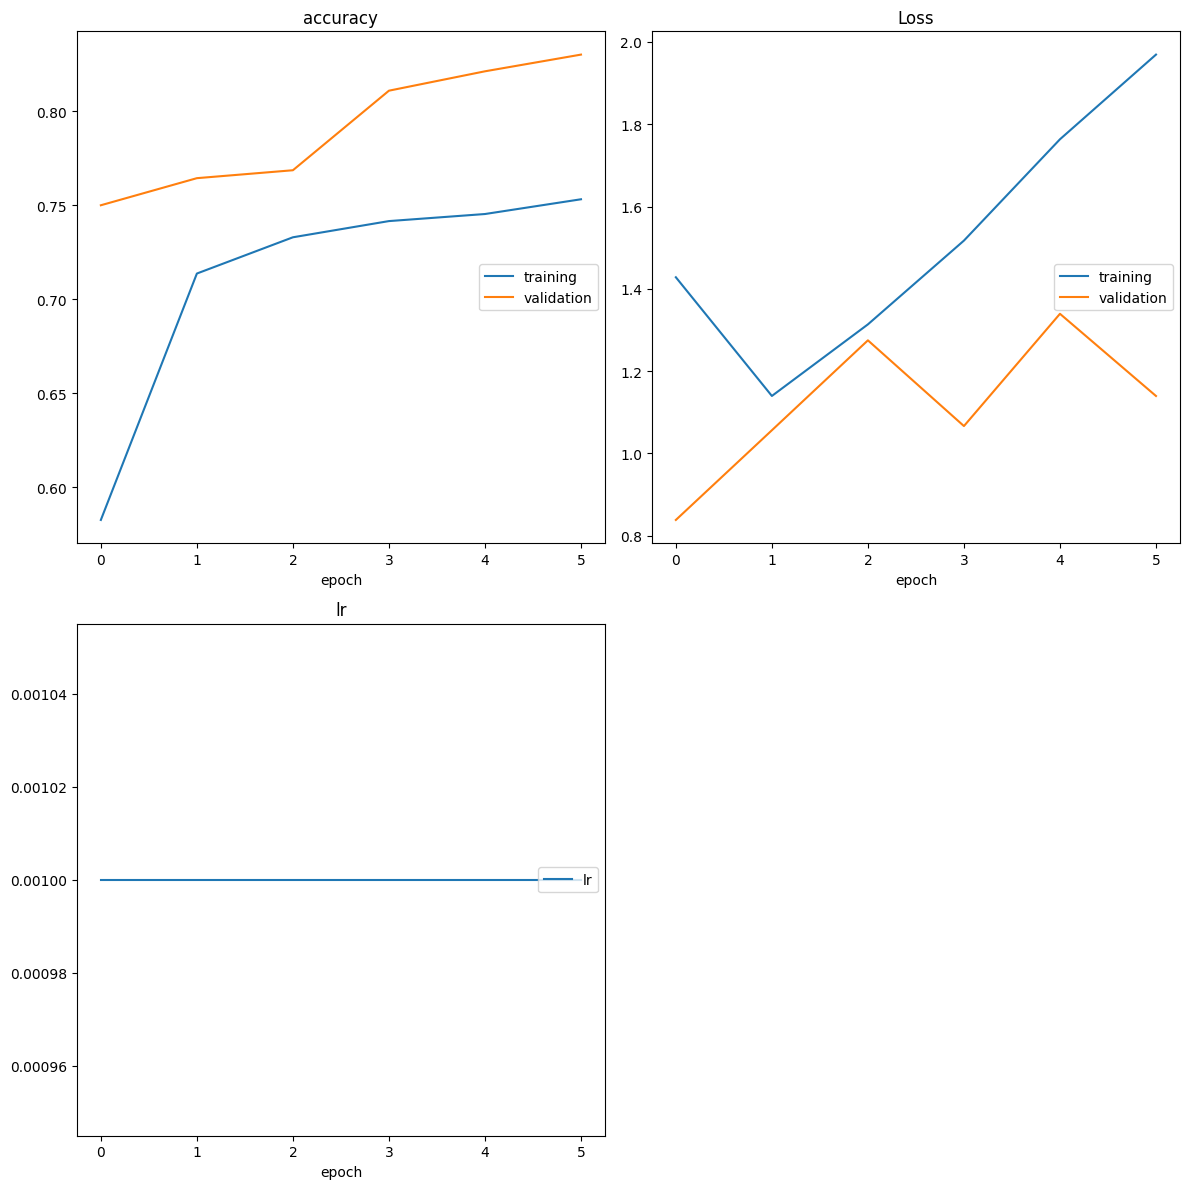

accuracy
	training         	 (min:    0.583, max:    0.753, cur:    0.753)
	validation       	 (min:    0.750, max:    0.830, cur:    0.830)
Loss
	training         	 (min:    1.140, max:    1.969, cur:    1.969)
	validation       	 (min:    0.838, max:    1.339, cur:    1.140)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
2196/2196 [==============================] - 1448s 659ms/step - loss: 1.9691 - accuracy: 0.7531 - val_loss: 1.1396 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 6: early stopping
CPU times: user 43min 2s, sys: 12min 43s, total: 55min 46s
Wall time: 2h 19min 20s


In [11]:
%%time 

with tf.device('/device:GPU:0'):
    history_0 = model.fit(train_generator,
            steps_per_epoch=train_generator.samples // batch_size,
            epochs=10,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // batch_size,
            callbacks=callbacks)

EarlyStopping stopped the training because the trend in train_loss and val_loss is going up. I will monitor now the val_accuracy and give it another try.

In [20]:

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Save model with best accuracy
checkpoint_best = ModelCheckpoint(
    'model_VGG16_2_best_accuracy.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Plot summary of training
plot_loss_1 = PlotLossesCallback()

# Combine all callbacks
callbacks = [early_stopping, reduce_lr, checkpoint_best, plot_loss_1]

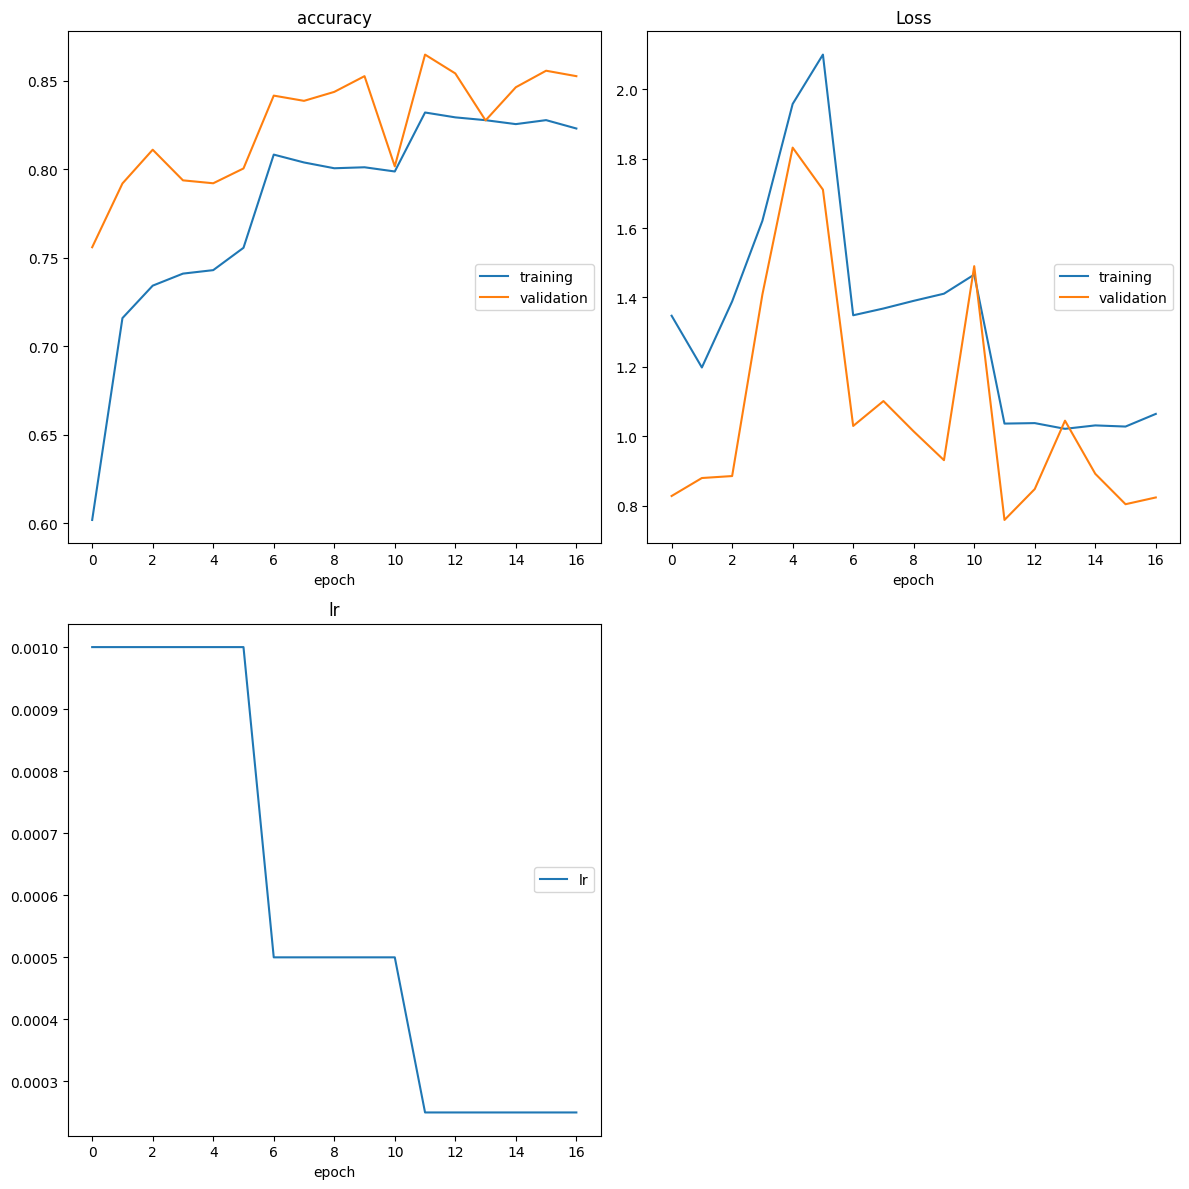

accuracy
	training         	 (min:    0.602, max:    0.832, cur:    0.823)
	validation       	 (min:    0.756, max:    0.865, cur:    0.853)
Loss
	training         	 (min:    1.022, max:    2.100, cur:    1.065)
	validation       	 (min:    0.759, max:    1.832, cur:    0.824)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
2196/2196 [==============================] - 1456s 663ms/step - loss: 1.0647 - accuracy: 0.8230 - val_loss: 0.8240 - val_accuracy: 0.8525 - lr: 2.5000e-04
Epoch 17: early stopping
CPU times: user 2h 5min 49s, sys: 40min 55s, total: 2h 46min 44s
Wall time: 7h 9min 12s


In [21]:
%%time 

with tf.device('/device:GPU:0'):
    history_0 = model.fit(train_generator,
            steps_per_epoch=train_generator.samples // batch_size,
            epochs=20,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // batch_size,
            callbacks=callbacks)

The training stopped early due to no improvement in val_accuracy after it peaked in epoch 11 at 0.865. Nevertheless, I will continue the training for 20 epochs to check if it might approach a converged state.

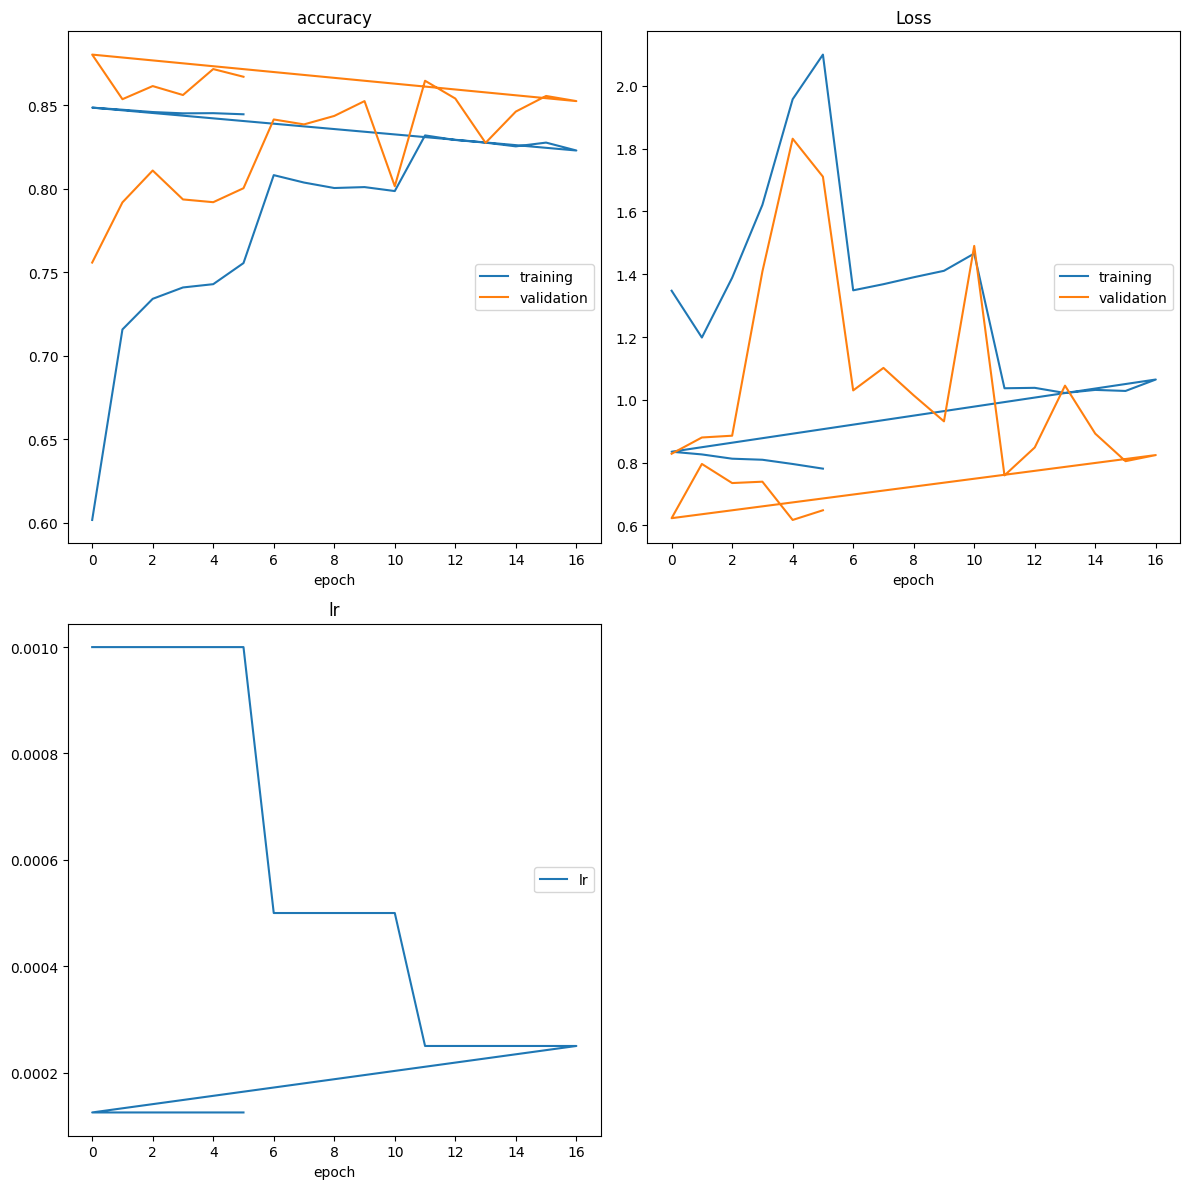

accuracy
	training         	 (min:    0.602, max:    0.849, cur:    0.845)
	validation       	 (min:    0.756, max:    0.880, cur:    0.867)
Loss
	training         	 (min:    0.781, max:    2.100, cur:    0.781)
	validation       	 (min:    0.617, max:    1.832, cur:    0.648)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
2196/2196 [==============================] - 1422s 647ms/step - loss: 0.7808 - accuracy: 0.8446 - val_loss: 0.6482 - val_accuracy: 0.8671 - lr: 1.2500e-04
Epoch 6: early stopping
CPU times: user 42min 30s, sys: 12min 18s, total: 54min 49s
Wall time: 2h 15min 28s


In [22]:
%%time 

with tf.device('/device:GPU:0'):
    history_2 = model.fit(train_generator,
            steps_per_epoch=train_generator.samples // batch_size,
            epochs=20,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // batch_size,
            callbacks=callbacks)


Again an early stopping after 6 epochs. The val_accuracy is plateauing around 0.86 and does not seem to converge more. I will try the same model but without augmentation now.

In [26]:
# Define the image generators for the training and validation set

batch_size = 32
num_classes = 38
img_size = (224, 224)

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)  # randomize the order of the samples to avoid overfitting

validation_generator = validation_datagen.flow_from_directory(
    valid_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)  # randomize the order of the samples to avoid overfitting

# Import the VGG16 model as a base line
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# base_model.trainable = False  #  freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for classification part 
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(rate=0.2))
model.add(Dense(512, activation="relu"))
model.add(Dropout(rate=0.2))
model.add(Dense(num_classes, activation="softmax"))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [27]:

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Save model with best accuracy
checkpoint_best = ModelCheckpoint(
    'model_VGG16_2_best_accuracy.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Plot summary of training
plot_loss_1 = PlotLossesCallback()

# Combine all callbacks
callbacks = [early_stopping, reduce_lr, checkpoint_best, plot_loss_1]

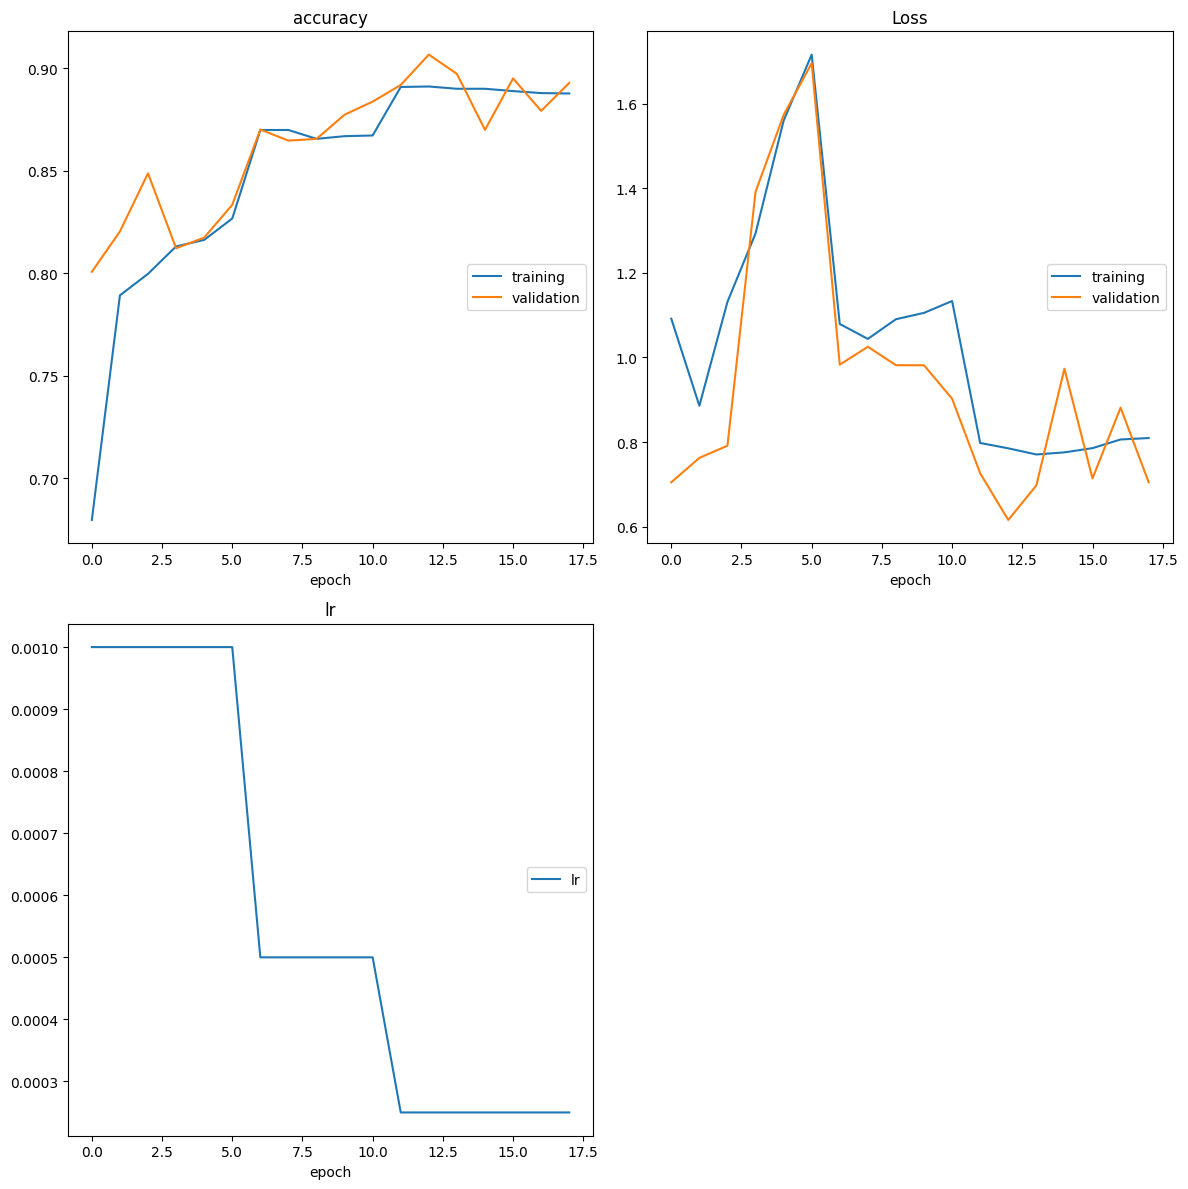

accuracy
	training         	 (min:    0.680, max:    0.891, cur:    0.888)
	validation       	 (min:    0.801, max:    0.907, cur:    0.893)
Loss
	training         	 (min:    0.771, max:    1.716, cur:    0.809)
	validation       	 (min:    0.616, max:    1.696, cur:    0.705)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
2196/2196 [==============================] - 1555s 708ms/step - loss: 0.8095 - accuracy: 0.8876 - val_loss: 0.7048 - val_accuracy: 0.8927 - lr: 2.5000e-04
Epoch 18: early stopping
CPU times: user 28min 4s, sys: 35min 39s, total: 1h 3min 43s
Wall time: 6h 43min 36s


In [28]:
%%time 

with tf.device('/device:GPU:0'):
    history = model.fit(train_generator,
            steps_per_epoch=train_generator.samples // batch_size,
            epochs=30,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // batch_size,
            callbacks=callbacks)

Oberservations:
- The train_accuracy is plateauing at around 0.88, val_loss is still fluctuating but close to train_accuracy.
- The learning rate has decreased to 3e-4, which is already quite small

-> With this small learning rate, probably there won't be any improvement in terms of convergency. I will now apply augmentations to the training set and continue the training to see if val_accuracy improves or remains stable.

In [30]:
# Save history of the former training in a new variable to resume the next training with it

history_0 = history

In [31]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)  # randomize the order of the samples to avoid overfitting

Found 70295 images belonging to 38 classes.


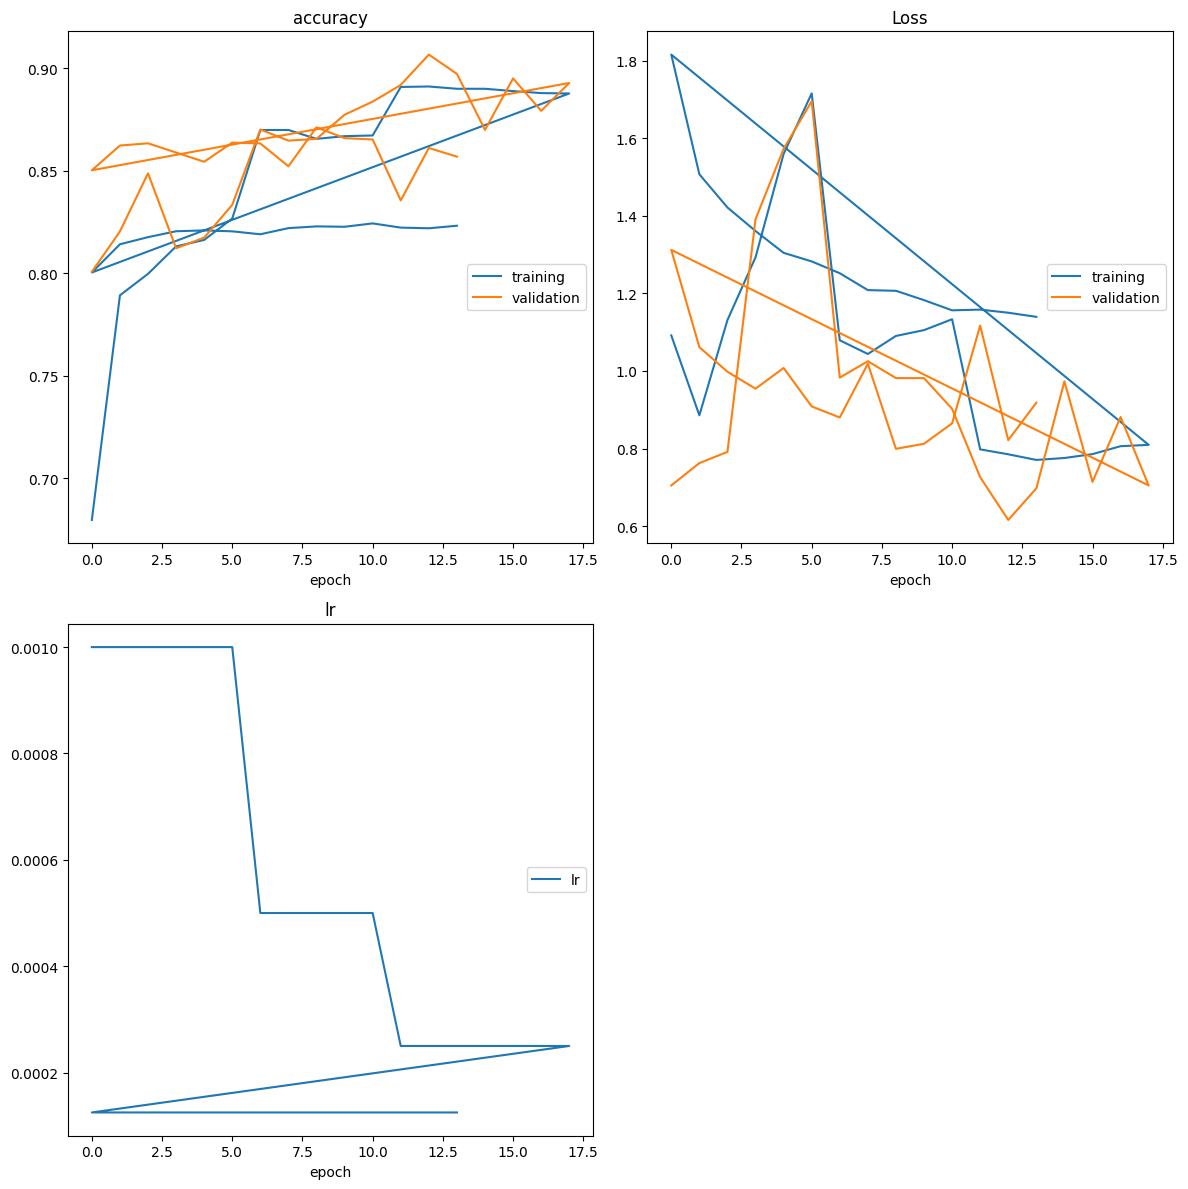

accuracy
	training         	 (min:    0.680, max:    0.891, cur:    0.823)
	validation       	 (min:    0.801, max:    0.907, cur:    0.857)
Loss
	training         	 (min:    0.771, max:    1.816, cur:    1.140)
	validation       	 (min:    0.616, max:    1.696, cur:    0.918)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
2196/2196 [==============================] - 1485s 676ms/step - loss: 1.1397 - accuracy: 0.8231 - val_loss: 0.9182 - val_accuracy: 0.8568 - lr: 1.2500e-04
Epoch 14: early stopping
CPU times: user 1h 46min 24s, sys: 35min 39s, total: 2h 22min 3s
Wall time: 6h 6min 9s


In [33]:
%%time 

with tf.device('/device:GPU:0'):
    history = model.fit(train_generator,
            steps_per_epoch=train_generator.samples // batch_size,
            epochs=20,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // batch_size,
            callbacks=callbacks)

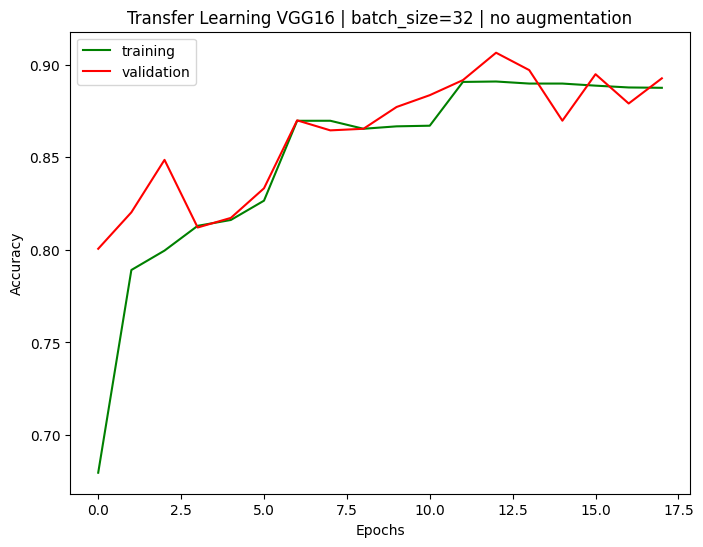

In [52]:
# # Having a look at the complete training history before and after applying agumentation
# history_1 = history

# # Merging the two Keras history objects
# def merge_histories(history1, history2):
#     merged_history = {}
#     for key in history1.keys():
#         merged_history[key] = history1[key] + history2[key]
#     return merged_history
train_acc = history_0.history['accuracy']
val_acc = history_0.history['val_accuracy']

plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(train_acc)), train_acc, c="g", label="training")
plt.plot(np.arange(len(val_acc)), val_acc, c="r", label="validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Transfer Learning VGG16 | batch_size=32 | no augmentation")
plt.legend()
plt.show()


Observations:
- After applying augmentations to the training set, there is a drop in the accuracies and an increase in losses. The val_accuracy is now plateauing aroung 0.86 which corresponds to the training performance where I applied augmentations right from the beginning. This consistency leads me to the conclusion that it does not make any difference if I apply augmentation right from the beginning or if I first train the model without it and apply it later on. 
- In my view, the learning rate is going down quite early with the effect that there is not much progress after some epochs. So far, the ReduceLROnPlateau callback was monitoring val_loss. Maybe I have to change this also to val_accuracy. 

**Increasing the batch_size to 64**

In [36]:
# Define the image generators for the training and validation set

batch_size = 64
num_classes = 38
img_size = (224, 224)

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)  # randomize the order of the samples to avoid overfitting

validation_generator = validation_datagen.flow_from_directory(
    valid_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)  # randomize the order of the samples to avoid overfitting

# Import the VGG16 model as a base line
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# base_model.trainable = False  #  freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for classification part 
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(rate=0.2))
model.add(Dense(512, activation="relu"))
model.add(Dropout(rate=0.2))
model.add(Dense(num_classes, activation="softmax"))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [37]:

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Save model with best accuracy
checkpoint_best = ModelCheckpoint(
    'model_VGG16_2_best_accuracy.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Plot summary of training
plot_loss_1 = PlotLossesCallback()

# Combine all callbacks
callbacks = [early_stopping, reduce_lr, checkpoint_best, plot_loss_1]

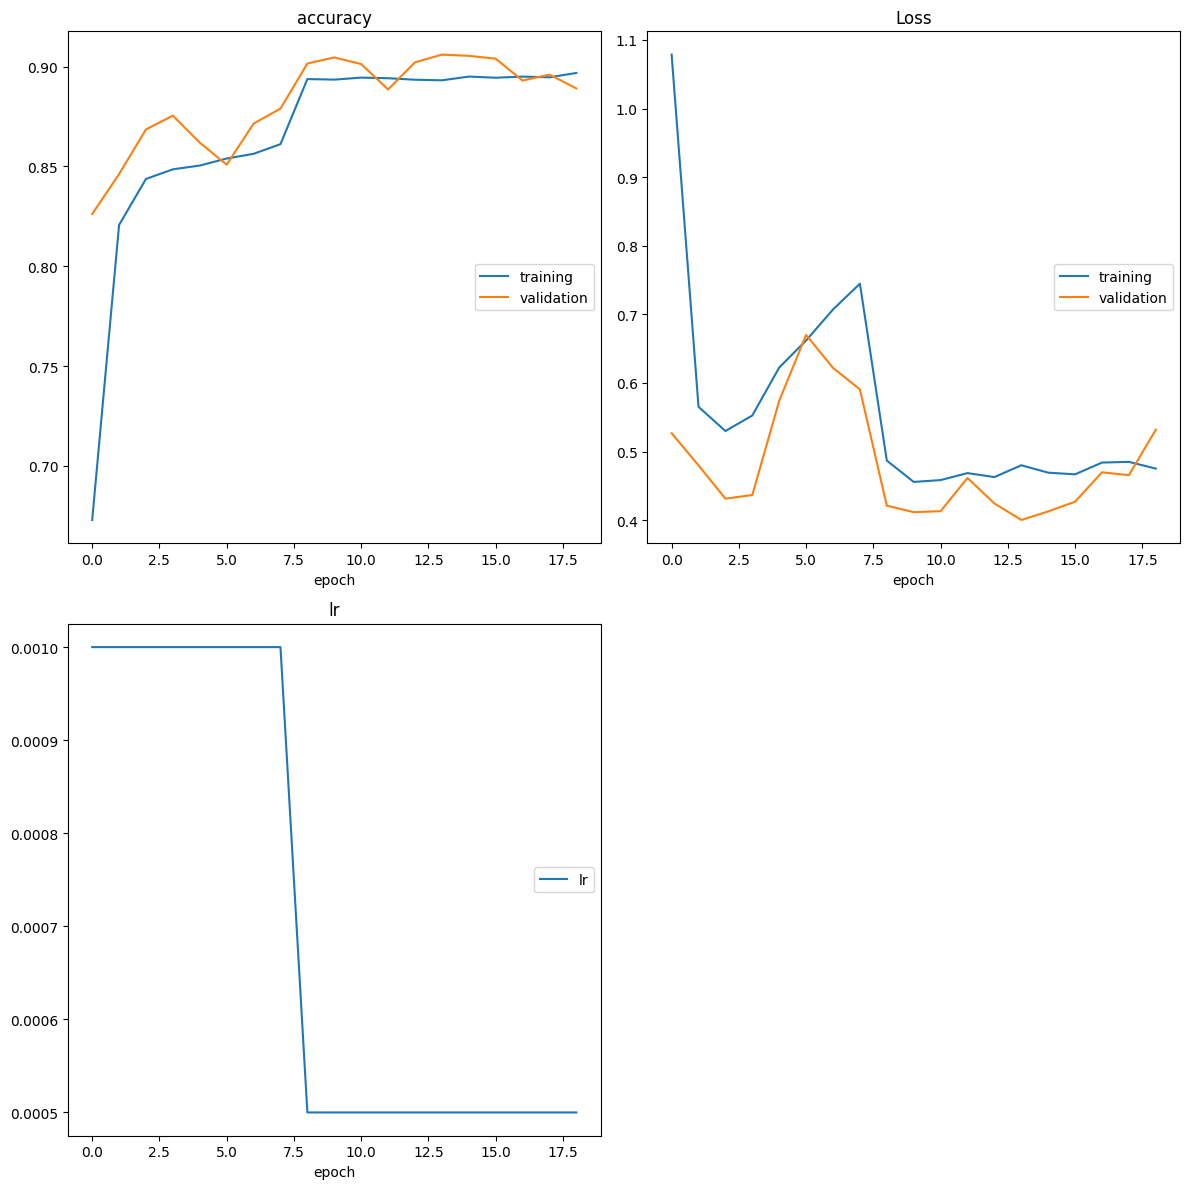

accuracy
	training         	 (min:    0.673, max:    0.897, cur:    0.897)
	validation       	 (min:    0.826, max:    0.906, cur:    0.889)
Loss
	training         	 (min:    0.456, max:    1.079, cur:    0.475)
	validation       	 (min:    0.400, max:    0.670, cur:    0.532)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
1098/1098 [==============================] - 1503s 1s/step - loss: 0.4752 - accuracy: 0.8968 - val_loss: 0.5319 - val_accuracy: 0.8891 - lr: 5.0000e-04
Epoch 19: early stopping
CPU times: user 28min 7s, sys: 1h 27min 26s, total: 1h 55min 34s
Wall time: 7h 53min 27s


In [38]:
%%time 

with tf.device('/device:GPU:0'):
    history = model.fit(train_generator,
            steps_per_epoch=train_generator.samples // batch_size,
            epochs=20,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // batch_size,
            callbacks=callbacks)

In [39]:
history_64_bs_0 = history

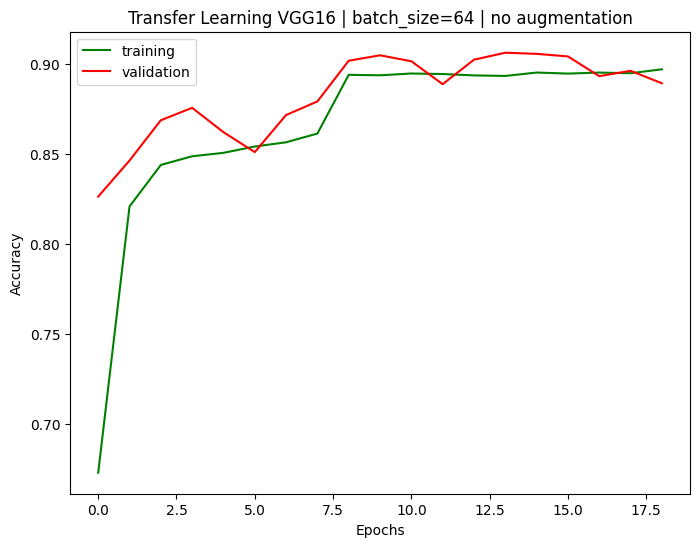

In [41]:
train_acc = history_64_bs_0.history['accuracy']
val_acc = history_64_bs_0.history['val_accuracy']

plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(train_acc)), train_acc, c="g", label="training")
plt.plot(np.arange(len(val_acc)), val_acc, c="r", label="validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Transfer Learning VGG16 | batch_size=64 | no augmentation")
plt.legend()
plt.show()

**Increasing the batch_size to 128**

In [54]:
# Define the image generators for the training and validation set

batch_size = 128
num_classes = 38
img_size = (224, 224)

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)  # randomize the order of the samples to avoid overfitting

validation_generator = validation_datagen.flow_from_directory(
    valid_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)  # randomize the order of the samples to avoid overfitting

# Import the VGG16 model as a base line
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# base_model.trainable = False  #  freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for classification part 
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(rate=0.2))
model.add(Dense(512, activation="relu"))
model.add(Dropout(rate=0.2))
model.add(Dense(num_classes, activation="softmax"))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [55]:

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Save model with best accuracy
checkpoint_best = ModelCheckpoint(
    'model_VGG16_2_best_accuracy.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Plot summary of training
plot_loss_1 = PlotLossesCallback()

# Combine all callbacks
callbacks = [early_stopping, reduce_lr, checkpoint_best, plot_loss_1]

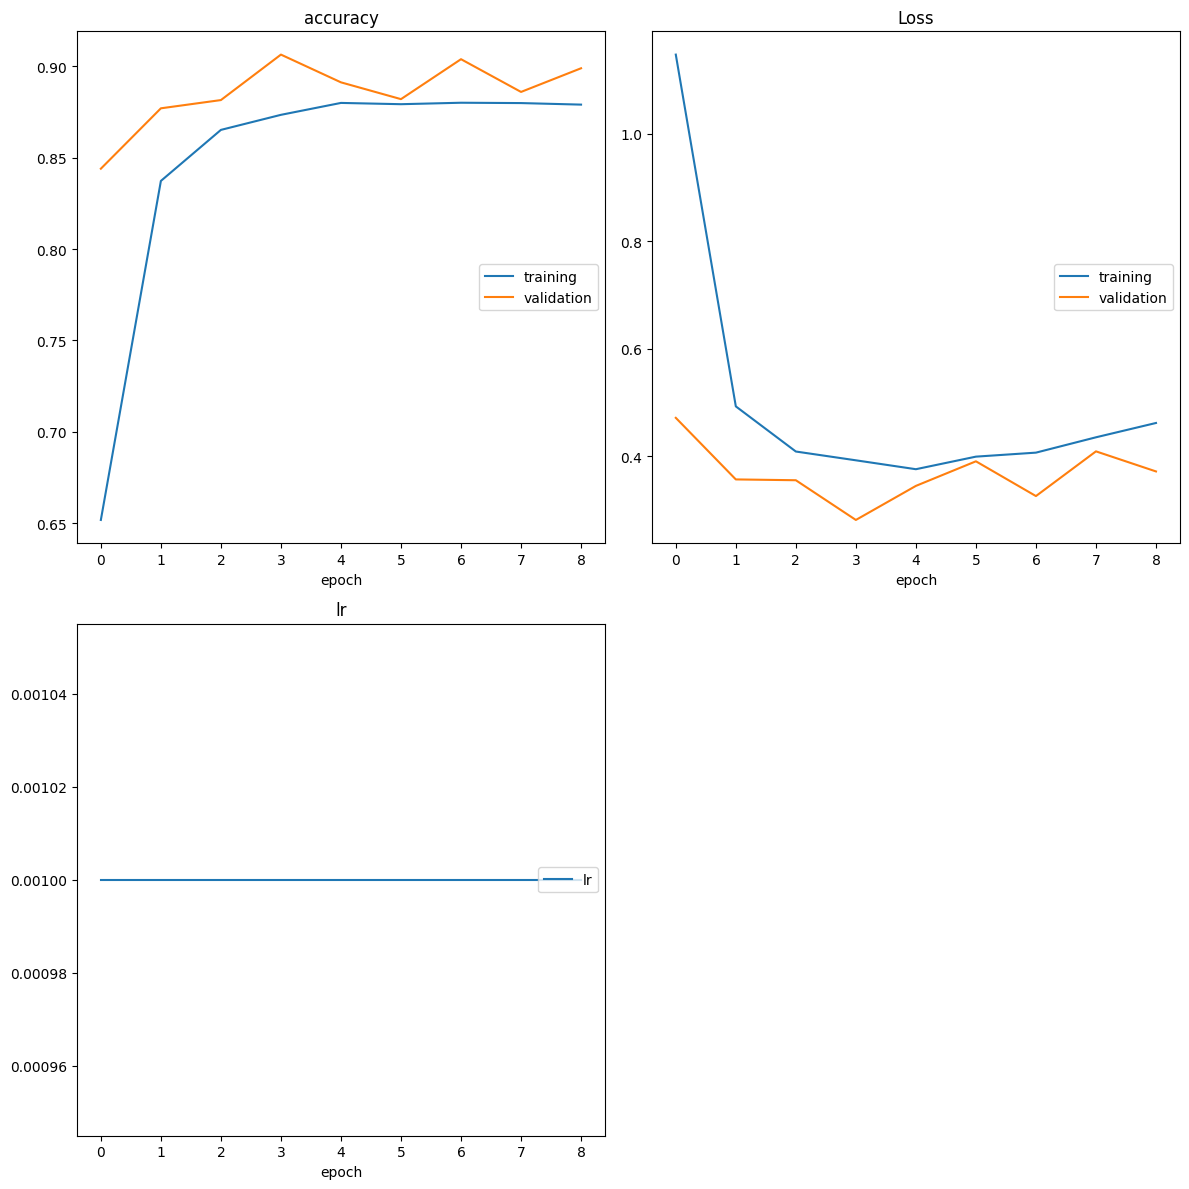

accuracy
	training         	 (min:    0.652, max:    0.880, cur:    0.879)
	validation       	 (min:    0.844, max:    0.906, cur:    0.899)
Loss
	training         	 (min:    0.376, max:    1.148, cur:    0.462)
	validation       	 (min:    0.281, max:    0.471, cur:    0.372)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
549/549 [==============================] - 1272s 2s/step - loss: 0.4619 - accuracy: 0.8790 - val_loss: 0.3717 - val_accuracy: 0.8988 - lr: 0.0010
Epoch 9: early stopping
CPU times: user 11min 17s, sys: 54min 59s, total: 1h 6min 17s
Wall time: 3h 15min 17s


In [56]:
%%time 

with tf.device('/device:GPU:0'):
    history = model.fit(train_generator,
            steps_per_epoch=train_generator.samples // batch_size,
            epochs=20,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // batch_size,
            callbacks=callbacks)

In [57]:
history_128_bs_0 = history

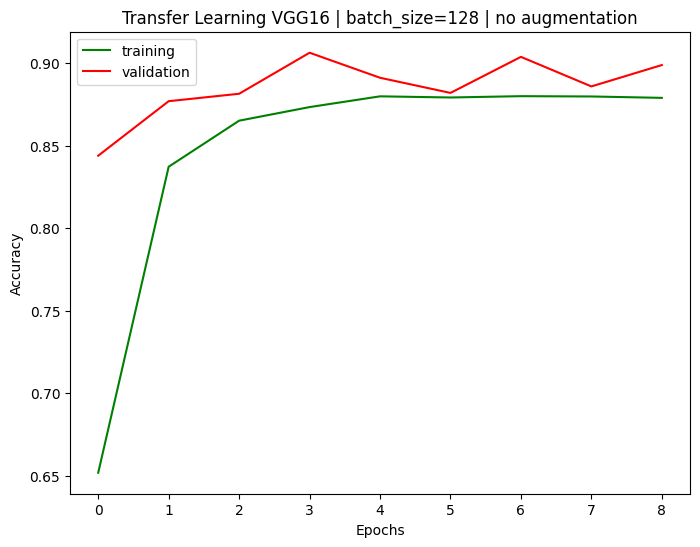

In [59]:
train_acc = history_128_bs_0.history['accuracy']
val_acc = history_128_bs_0.history['val_accuracy']

plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(train_acc)), train_acc, c="g", label="training")
plt.plot(np.arange(len(val_acc)), val_acc, c="r", label="validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Transfer Learning VGG16 | batch_size=128 | no augmentation")
plt.legend()
plt.show()

Adding augmentation

In [61]:
# Define the image generators for the training and validation set

batch_size = 128
num_classes = 38
img_size = (224, 224)

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)  # randomize the order of the samples to avoid overfitting

validation_generator = validation_datagen.flow_from_directory(
    valid_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)  # randomize the order of the samples to avoid overfitting

# Import the VGG16 model as a base line
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# base_model.trainable = False  #  freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for classification part 
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(rate=0.2))
model.add(Dense(512, activation="relu"))
model.add(Dropout(rate=0.2))
model.add(Dense(num_classes, activation="softmax"))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [62]:

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Save model with best accuracy
checkpoint_best = ModelCheckpoint(
    'model_VGG16_2_best_accuracy.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Plot summary of training
plot_loss_1 = PlotLossesCallback()

# Combine all callbacks
callbacks = [early_stopping, reduce_lr, checkpoint_best, plot_loss_1]

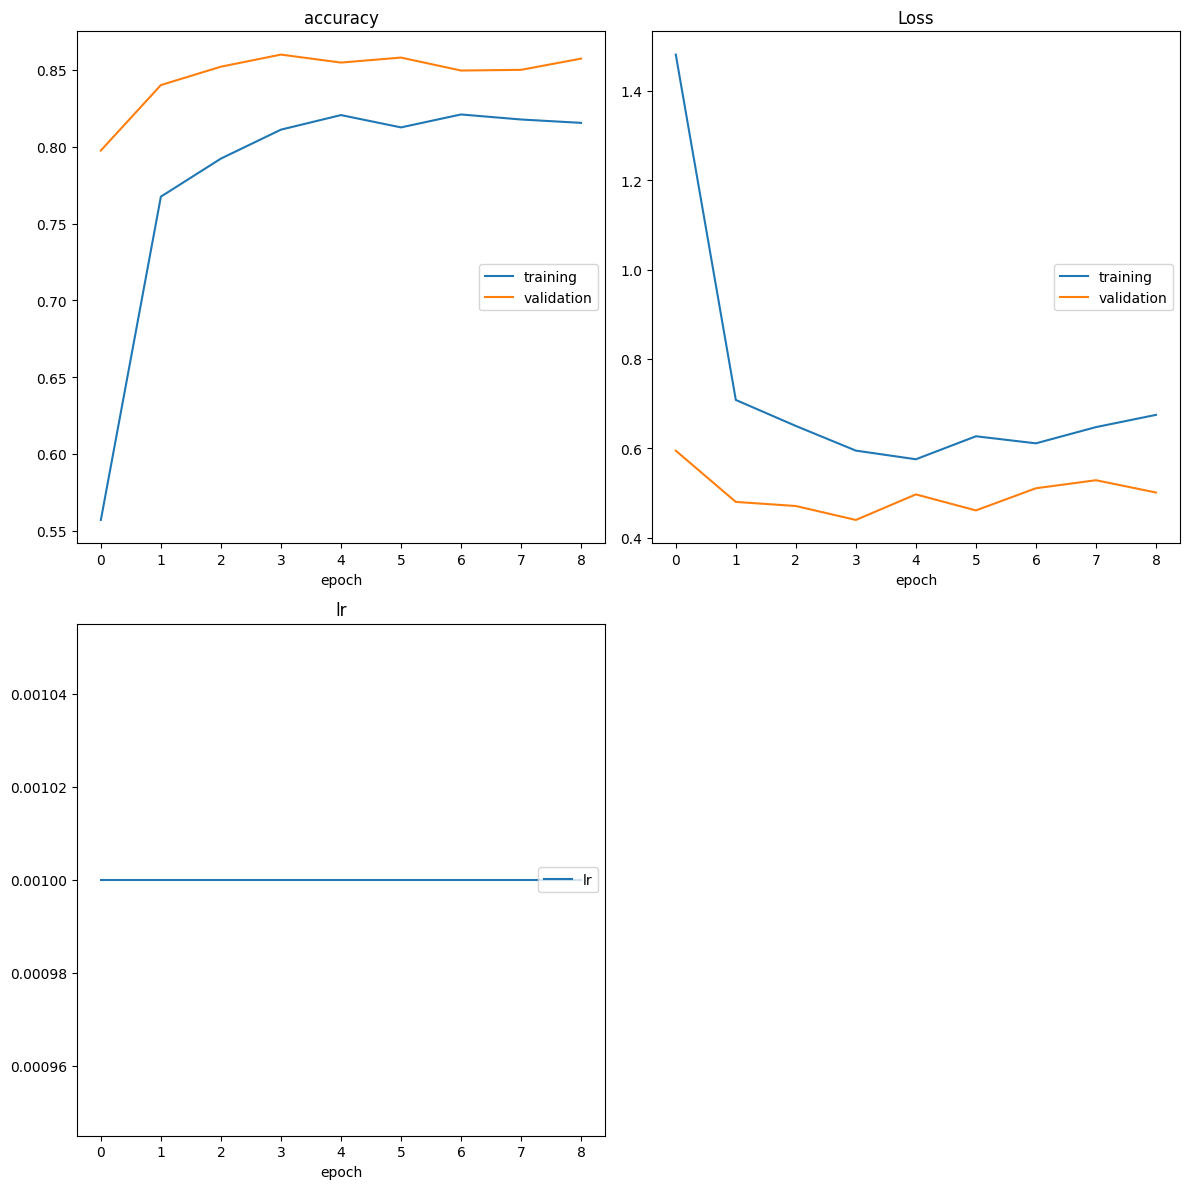

accuracy
	training         	 (min:    0.557, max:    0.821, cur:    0.816)
	validation       	 (min:    0.798, max:    0.860, cur:    0.857)
Loss
	training         	 (min:    0.576, max:    1.481, cur:    0.675)
	validation       	 (min:    0.440, max:    0.595, cur:    0.501)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
549/549 [==============================] - 1455s 3s/step - loss: 0.6749 - accuracy: 0.8156 - val_loss: 0.5012 - val_accuracy: 0.8574 - lr: 0.0010
Epoch 9: early stopping
CPU times: user 1h 15min 2s, sys: 1h 4min 26s, total: 2h 19min 28s
Wall time: 3h 30min 7s


In [63]:
%%time 

with tf.device('/device:GPU:0'):
    history = model.fit(train_generator,
            steps_per_epoch=train_generator.samples // batch_size,
            epochs=20,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // batch_size,
            callbacks=callbacks)

# 3 Extraction and fine-tuning

In [69]:
# Define the image generators for the training and validation set

batch_size = 64
num_classes = 38
img_size = (224, 224)

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)  # randomize the order of the samples to avoid overfitting

validation_generator = validation_datagen.flow_from_directory(
    valid_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)  # randomize the order of the samples to avoid overfitting

# Import the VGG16 model as a base line
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# base_model.trainable = False  #  freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for classification part 
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(rate=0.2))
model.add(Dense(512, activation="relu"))
model.add(Dropout(rate=0.2))
model.add(Dense(num_classes, activation="softmax"))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [70]:

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Save model with best accuracy
checkpoint_best = ModelCheckpoint(
    'TL_VGG16_64_bs_non-augmented_best_accuracy.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Plot summary of training
plot_loss_1 = PlotLossesCallback()

# Combine all callbacks
callbacks = [early_stopping, reduce_lr, checkpoint_best, plot_loss_1]

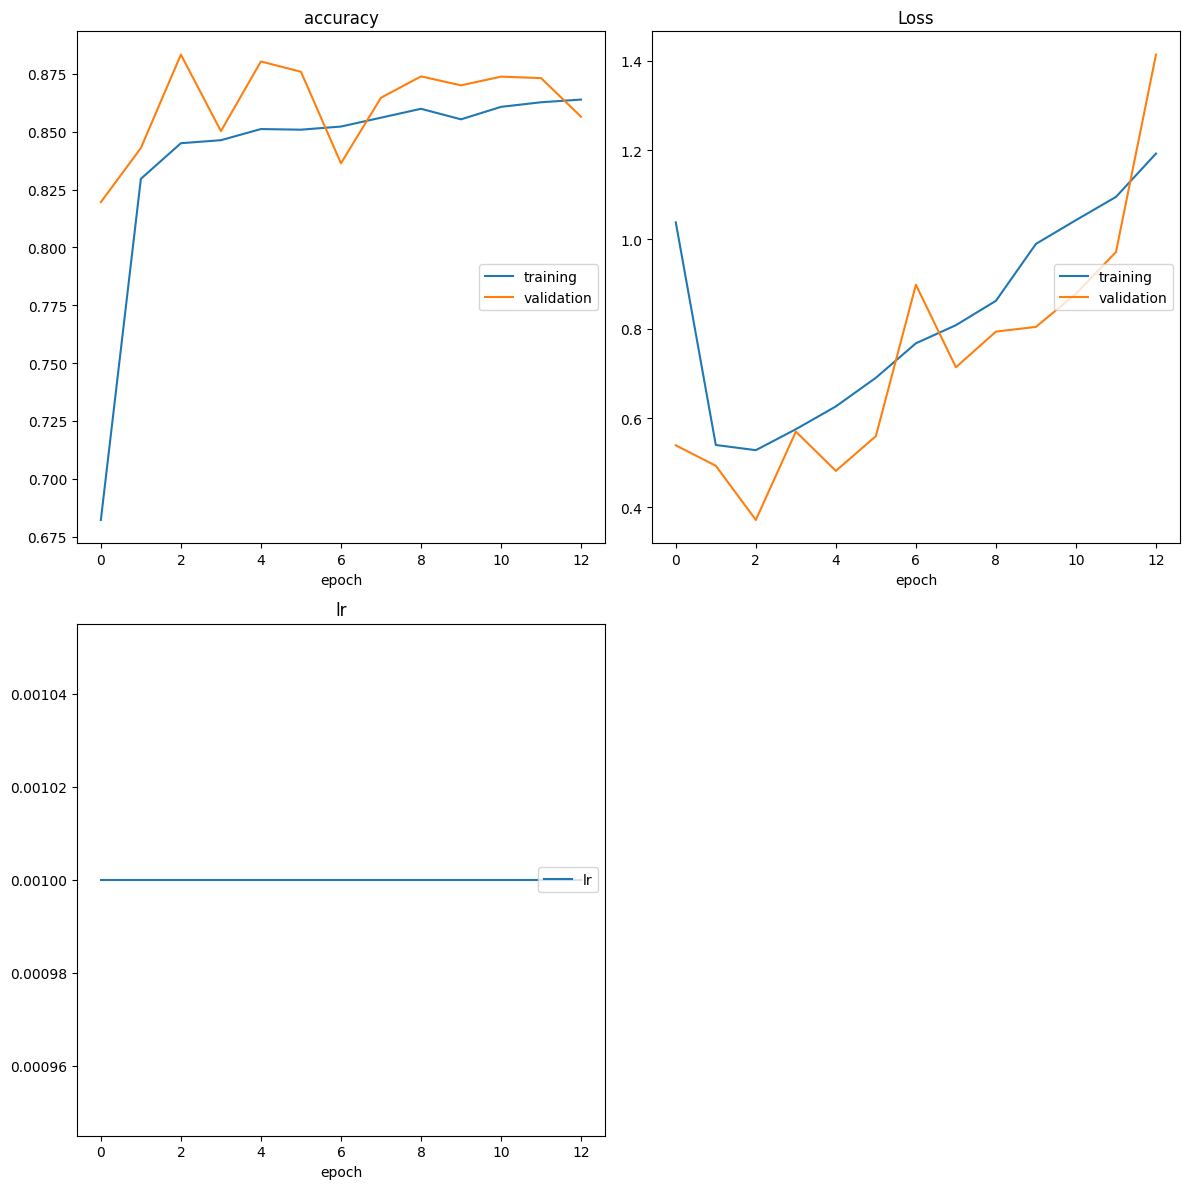

accuracy
	training         	 (min:    0.682, max:    0.864, cur:    0.864)
	validation       	 (min:    0.820, max:    0.883, cur:    0.856)
Loss
	training         	 (min:    0.528, max:    1.192, cur:    1.192)
	validation       	 (min:    0.372, max:    1.414, cur:    1.414)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
1098/1098 [==============================] - 1232s 1s/step - loss: 1.1922 - accuracy: 0.8639 - val_loss: 1.4139 - val_accuracy: 0.8565 - lr: 0.0010
Epoch 13: early stopping
CPU times: user 18min 5s, sys: 55min 38s, total: 1h 13min 43s
Wall time: 4h 21min 46s


In [67]:
%%time 

with tf.device('/device:GPU:0'):
    history = model.fit(train_generator,
            steps_per_epoch=train_generator.samples // batch_size,
            epochs=50,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // batch_size,
            callbacks=callbacks)

The losses 

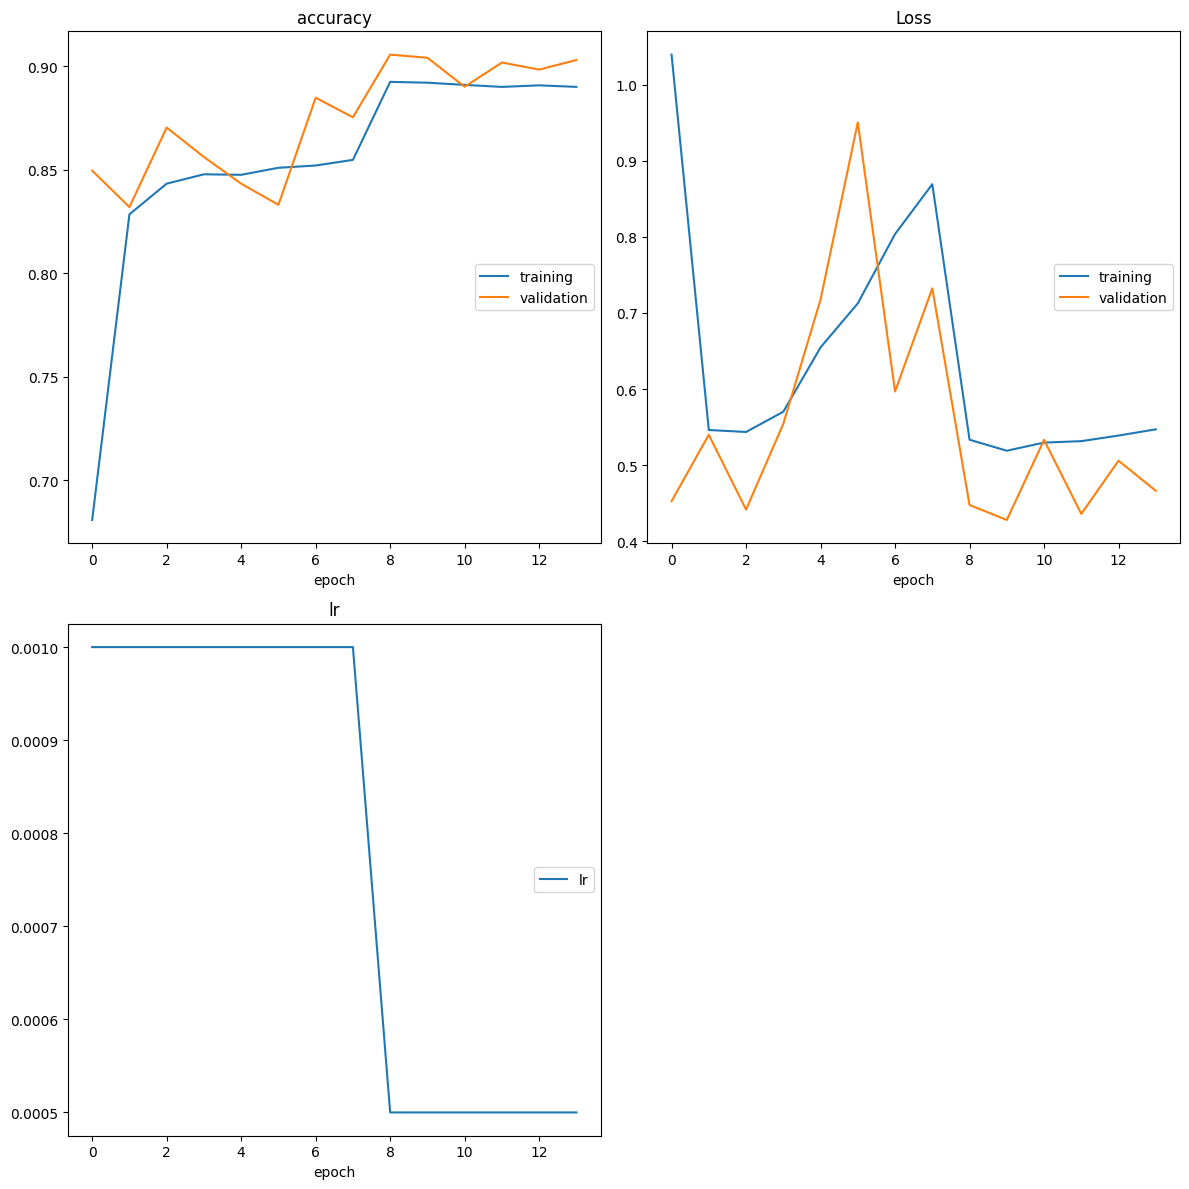

accuracy
	training         	 (min:    0.681, max:    0.892, cur:    0.890)
	validation       	 (min:    0.832, max:    0.906, cur:    0.903)
Loss
	training         	 (min:    0.519, max:    1.039, cur:    0.547)
	validation       	 (min:    0.428, max:    0.950, cur:    0.466)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
1098/1098 [==============================] - 1149s 1s/step - loss: 0.5472 - accuracy: 0.8899 - val_loss: 0.4664 - val_accuracy: 0.9029 - lr: 5.0000e-04
Epoch 14: early stopping
CPU times: user 19min 7s, sys: 59min 23s, total: 1h 18min 31s
Wall time: 4h 17min 8s


In [71]:
%%time 

with tf.device('/device:GPU:0'):
    history = model.fit(train_generator,
            steps_per_epoch=train_generator.samples // batch_size,
            epochs=50,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // batch_size,
            callbacks=callbacks)

In [72]:
# Load the current best model to continue training

model = load_model("TL_VGG16_64_bs_non-augmented_best_accuracy.h5")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

In [73]:
# Unfreeze the last 4 layers of the base model
for layer in base_model.layers[-3:]:
    layer.trainable = True

# Compile with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [74]:

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Save model with best accuracy
checkpoint_best = ModelCheckpoint(
    'TL_VGG16_64_bs_non-augmented_best_accuracy_fine.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Plot summary of training
plot_loss_1 = PlotLossesCallback()

# Combine all callbacks
callbacks = [early_stopping, reduce_lr, checkpoint_best, plot_loss_1]

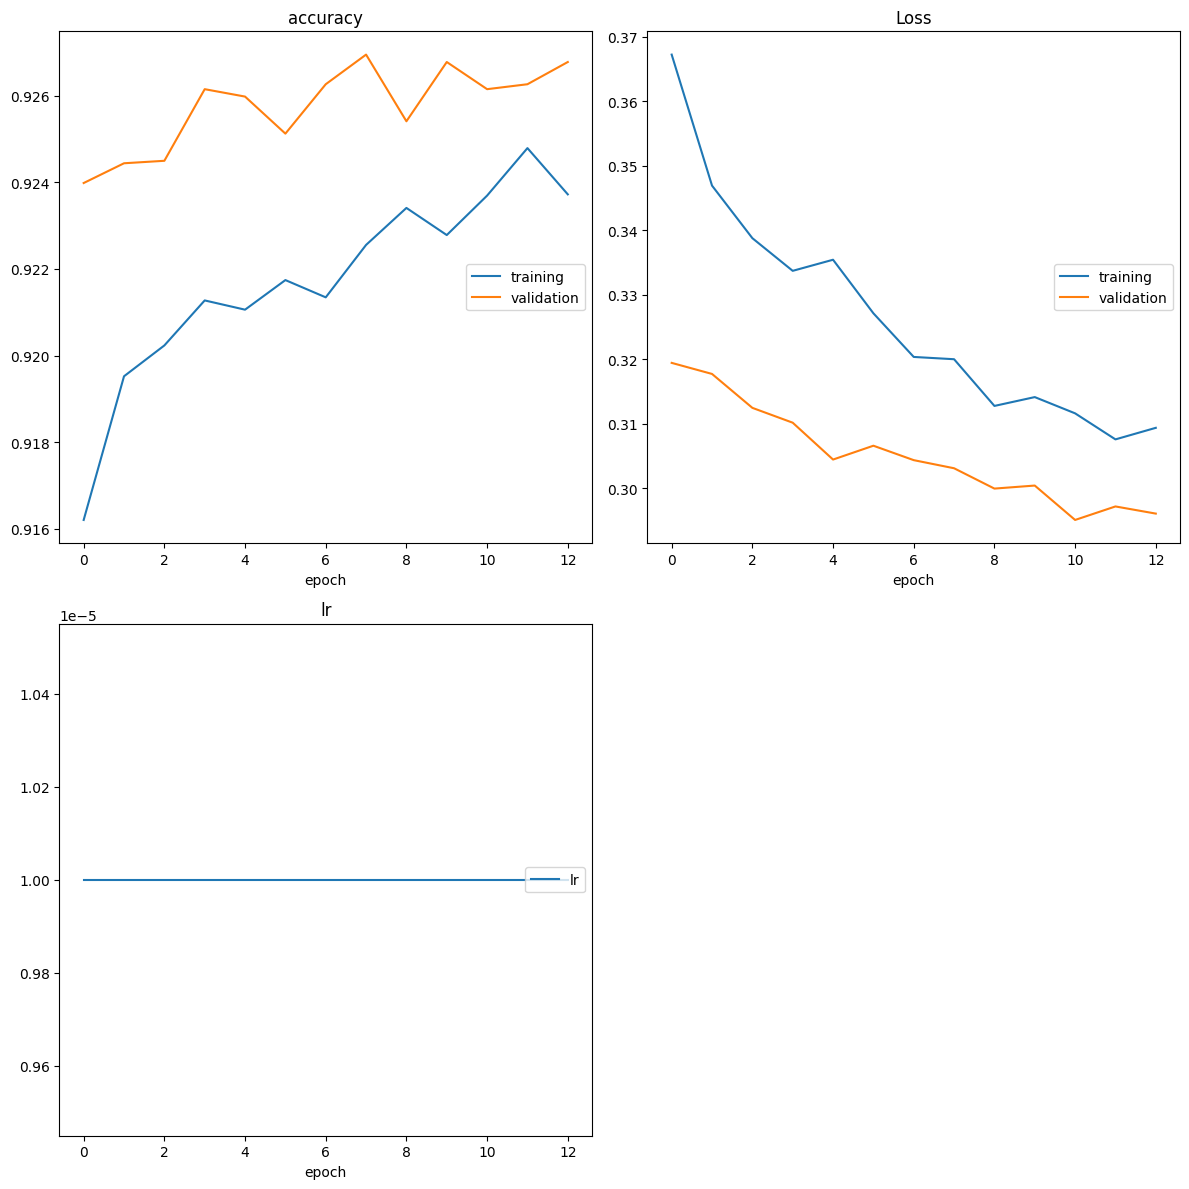

accuracy
	training         	 (min:    0.916, max:    0.925, cur:    0.924)
	validation       	 (min:    0.924, max:    0.927, cur:    0.927)
Loss
	training         	 (min:    0.308, max:    0.367, cur:    0.309)
	validation       	 (min:    0.295, max:    0.319, cur:    0.296)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)
1098/1098 [==============================] - 1158s 1s/step - loss: 0.3094 - accuracy: 0.9237 - val_loss: 0.2961 - val_accuracy: 0.9268 - lr: 1.0000e-05
Epoch 13: early stopping
CPU times: user 17min 41s, sys: 58min 24s, total: 1h 16min 6s
Wall time: 4h 3min 2s


In [75]:
%%time 

with tf.device('/device:GPU:0'):
    history = model.fit(train_generator,
            steps_per_epoch=train_generator.samples // batch_size,
            epochs=20,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // batch_size,
            callbacks=callbacks)

In [76]:
history_fine_0 = history

In [77]:
# Unfreeze the last 4 layers of the base model
for layer in base_model.layers[-6:]:
    layer.trainable = True

# Compile with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [78]:

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Save model with best accuracy
checkpoint_best = ModelCheckpoint(
    'TL_VGG16_64_bs_non-augmented_best_accuracy_fine_1.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Plot summary of training
plot_loss_1 = PlotLossesCallback()

# Combine all callbacks
callbacks = [early_stopping, reduce_lr, checkpoint_best, plot_loss_1]

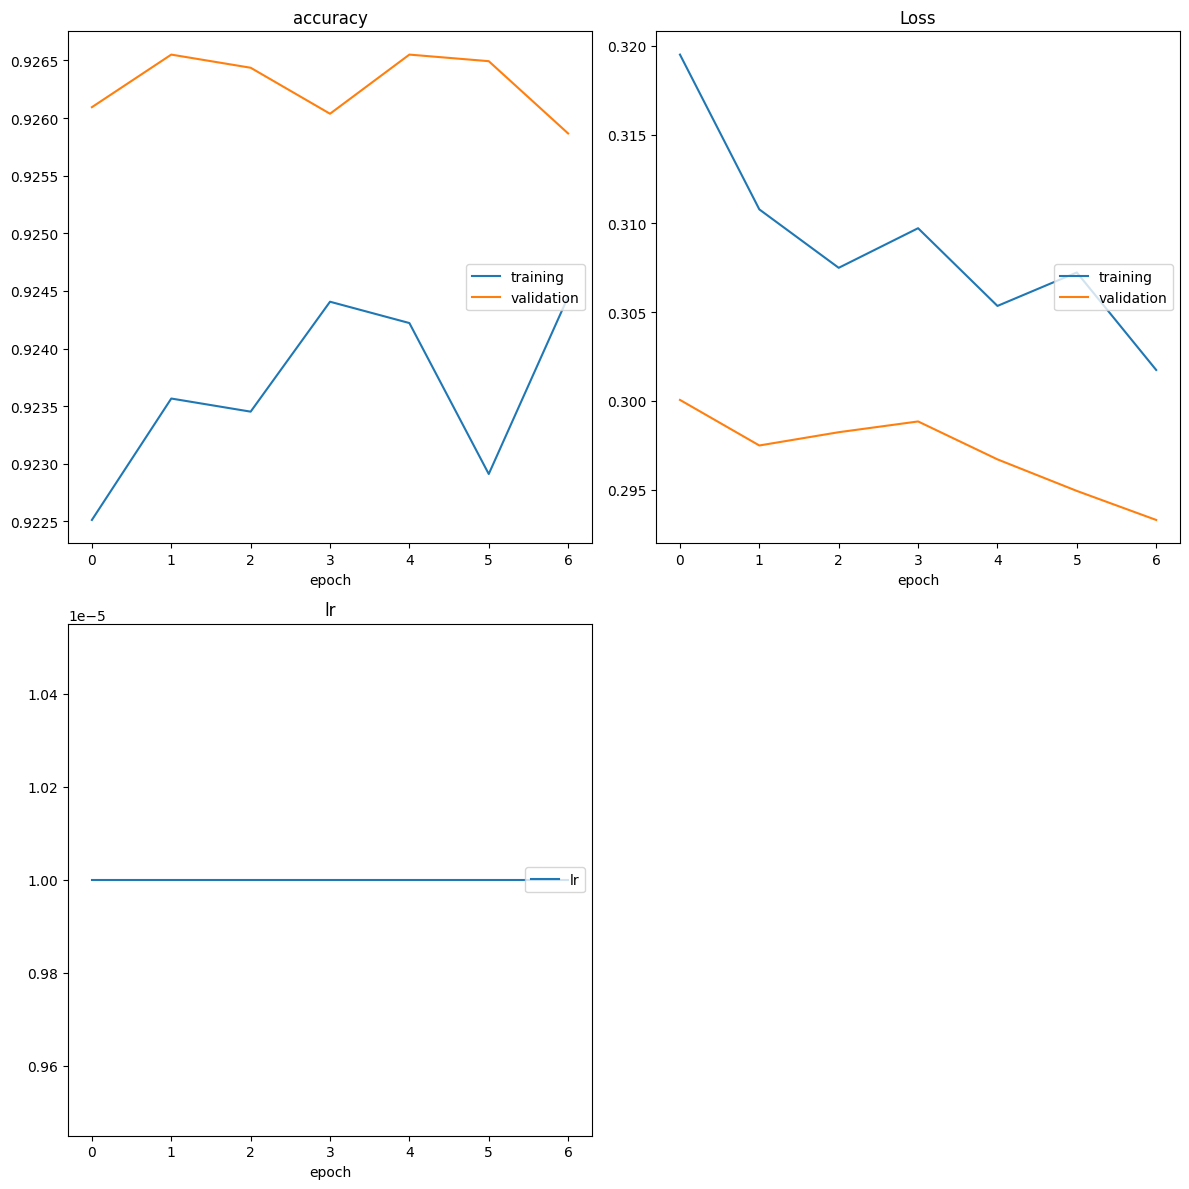

accuracy
	training         	 (min:    0.923, max:    0.924, cur:    0.924)
	validation       	 (min:    0.926, max:    0.927, cur:    0.926)
Loss
	training         	 (min:    0.302, max:    0.320, cur:    0.302)
	validation       	 (min:    0.293, max:    0.300, cur:    0.293)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)
1098/1098 [==============================] - 1166s 1s/step - loss: 0.3017 - accuracy: 0.9244 - val_loss: 0.2933 - val_accuracy: 0.9259 - lr: 1.0000e-05
Epoch 7: early stopping
CPU times: user 9min 43s, sys: 30min 15s, total: 39min 59s
Wall time: 2h 9min 18s


In [79]:
%%time 

with tf.device('/device:GPU:0'):
    history_fine_1 = model.fit(train_generator,
            steps_per_epoch=train_generator.samples // batch_size,
            epochs=20,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // batch_size,
            callbacks=callbacks)

In [80]:
# Unfreeze the last 4 layers of the base model
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Compile with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [81]:

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Save model with best accuracy
checkpoint_best = ModelCheckpoint(
    'TL_VGG16_64_bs_non-augmented_best_accuracy_fine_2.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Plot summary of training
plot_loss_1 = PlotLossesCallback()

# Combine all callbacks
callbacks = [early_stopping, reduce_lr, checkpoint_best, plot_loss_1]

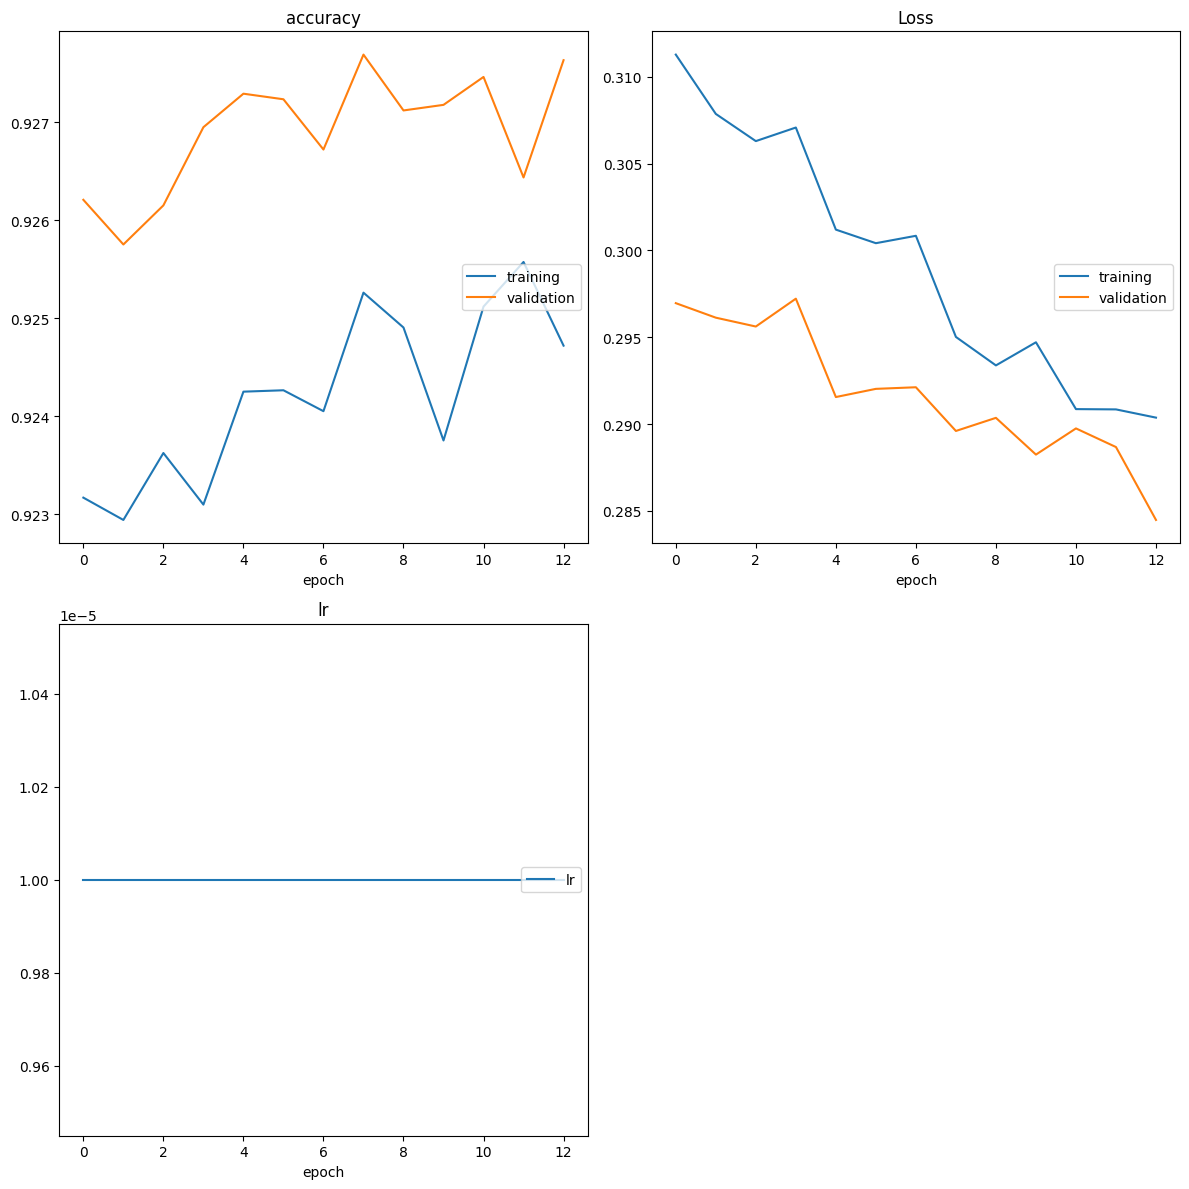

accuracy
	training         	 (min:    0.923, max:    0.926, cur:    0.925)
	validation       	 (min:    0.926, max:    0.928, cur:    0.928)
Loss
	training         	 (min:    0.290, max:    0.311, cur:    0.290)
	validation       	 (min:    0.284, max:    0.297, cur:    0.284)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)
1098/1098 [==============================] - 1182s 1s/step - loss: 0.2904 - accuracy: 0.9247 - val_loss: 0.2845 - val_accuracy: 0.9276 - lr: 1.0000e-05
Epoch 13: early stopping
CPU times: user 18min 3s, sys: 56min 4s, total: 1h 14min 8s
Wall time: 4h 5min 54s


In [82]:
%%time 

with tf.device('/device:GPU:0'):
    history_fine_2 = model.fit(train_generator,
            steps_per_epoch=train_generator.samples // batch_size,
            epochs=20,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // batch_size,
            callbacks=callbacks)

In [84]:
# # Define fucntion for loading and preprocessing the test images
def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224), color_mode='rgb')
    img_array = img_to_array(img)
    img_array = img_array.astype('float32') / 255.0
    return img_array

test_images = []
for image_file in os.listdir(test_path):
    image_path = os.path.join(test_path, image_file)
    img_array = load_and_preprocess_image(image_path)
    test_images.append(img_array)

test_images = np.array(test_images)

predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

class_indices = train_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}
predicted_classes_names = [class_names[idx] for idx in predicted_classes]

for prediction, true_class in zip(predicted_classes_names, os.listdir(test_path)):
    print("Prediction:", prediction, "\t True class:", true_class)

2024-12-22 10:46:20.545502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 4s 4s/step
Prediction: Squash___Powdery_mildew 	 True class: AppleScab3.JPG
Prediction: Tomato___Late_blight 	 True class: TomatoEarlyBlight2.JPG
Prediction: Tomato___Target_Spot 	 True class: TomatoEarlyBlight3.JPG
Prediction: Potato___healthy 	 True class: PotatoHealthy1.JPG
Prediction: Apple___Apple_scab 	 True class: AppleScab2.JPG
Prediction: Tomato___Early_blight 	 True class: TomatoEarlyBlight1.JPG
Prediction: Potato___healthy 	 True class: PotatoHealthy2.JPG
Prediction: Apple___Apple_scab 	 True class: AppleScab1.JPG
Prediction: Tomato___Early_blight 	 True class: TomatoEarlyBlight4.JPG
Prediction: Tomato___Target_Spot 	 True class: TomatoEarlyBlight5.JPG
Prediction: Tomato___Early_blight 	 True class: TomatoEarlyBlight6.JPG
Prediction: Potato___Early_blight 	 True class: PotatoEarlyBlight4.JPG
Prediction: Potato___Early_blight 	 True class: PotatoEarlyBlight5.JPG
Prediction: Potato___Early_blight 	 True class: PotatoEarlyBlight2.JPG
Predi

In [85]:
test_comparison = pd.DataFrame({
    "Predictions": predicted_classes_names,
    "True_classes": os.listdir(test_path)
})

test_comparison["Correct"] = [0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

display(test_comparison)

,Predictions,True_classes,Correct
0,Squash___Powdery_mildew,AppleScab3.JPG,0
1,Tomato___Late_blight,TomatoEarlyBlight2.JPG,1
2,Tomato___Target_Spot,TomatoEarlyBlight3.JPG,0
3,Potato___healthy,PotatoHealthy1.JPG,1
4,Apple___Apple_scab,AppleScab2.JPG,1
5,Tomato___Early_blight,TomatoEarlyBlight1.JPG,1
6,Potato___healthy,PotatoHealthy2.JPG,1
7,Apple___Apple_scab,AppleScab1.JPG,1
8,Tomato___Early_blight,TomatoEarlyBlight4.JPG,1
9,Tomato___Target_Spot,TomatoEarlyBlight5.JPG,0


In [86]:
test_comparison["Correct"].value_counts(normalize=True)

Correct
1    0.878788
0    0.121212
Name: proportion, dtype: float64